## PROGETTO DI MACHINE AND DEEP LEARNING - "Audio"

Si vuole modellare un sistema di apprendimento automatico mediante l’utilizzo del linguaggio di programmazione Python. 
L'oggetto delle analisi di questo notebook è un set di Audio.
Le appena citate analisi, verranno condotte utilizzando diversi strumenti e algoritmi per la classificazione, compresa anche una rete neurale convoluzionale. Verrà effettuata anche anomaly detection con l'approccio "OneClassSVM" il cui training set dovrà essere composto dalla classe più numerosa del dataset ed il test set da quelle restanti. Per la valutazione della qualità del detector si farà uso delle curve di ROC.

Infine, i risultati saranno valutati per misurare le prestazioni mediante il calcolo di diverse misure quali: Accuratezza; Precision; Recall; F1.


## Indice:


1.   **Get the data**
2.  **Data Analysis**
3.  **Preparazione dei dati**
4. **Classificazione**
5. **Anomaly Detection**

## 1 - Get the data & Data Analysis
Effettuiamo le import necessarie

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import librosa
import IPython.display as ipd
import librosa.display

import soundfile as sf
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, roc_curve, auc, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope

import scikitplot as skplt
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Activations
import tensorflow.keras.optimizers as Optimizer

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D


dataset_dir = os.path.join("Datasets/audio-2")
modelli_dir = os.path.join("Modelli/Audio")
datasets = os.path.join("Datasets/feature_maps")

Per leggere gli audio andremo ad utilizzare la libreria librosa.
Vadiamo gli esempi di elaborazone su un elemento.

In [2]:
#path of the audio file
audio_data = 'Datasets/audio-2/bed/00f0204f_nohash_0.wav'
ipd.Audio(audio_data)

Plottiamo l'array dell'audio utilizzando **librosa.display.waveplot**. Ciò restituisce una serie temporale audio come un array numpy con una frequenza di campionamento predefinita (sr) di 22KHZ mono.

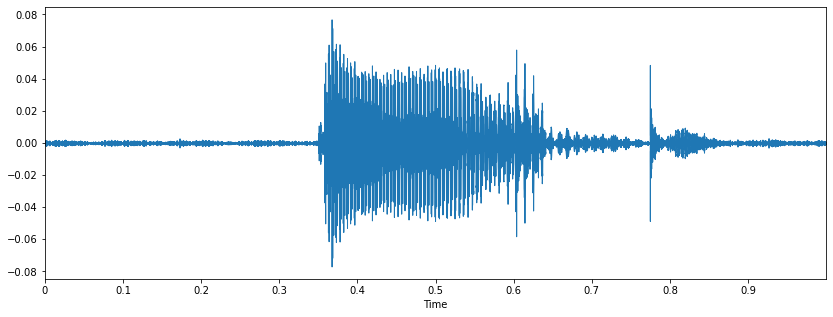

In [4]:
plt.figure(figsize=(14, 5))
x,sr=librosa.load(audio_data)
librosa.display.waveplot(x, sr)

Possiamo cambiare questo comportamento ricampionando a 44,1 KHz.

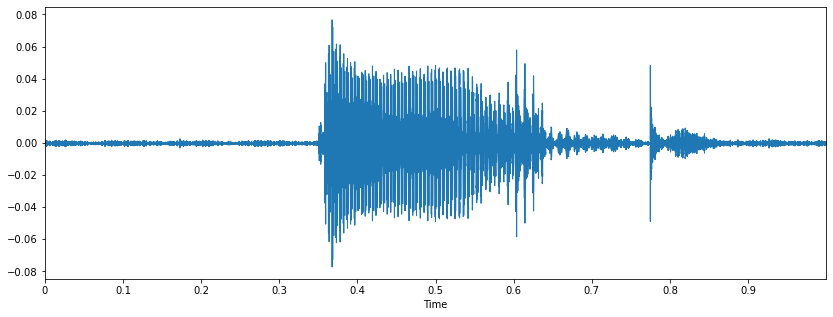

In [4]:
plt.figure(figsize=(14, 5))
y,sr2=librosa.load(audio_data, sr=44100)
librosa.display.waveplot(y, sr2)

La  frequenza di campionamento  è il numero di campioni di audio trasportati al secondo, misurato in Hz o kHz.

Uno spettrogramma è un modo visivo di rappresentare la forza del segnale, o " volume ", di un segnale nel tempo a varie frequenze presenti in una particolare forma d'onda. Non solo si può vedere se c'è più o meno energia, ad esempio, a 2 Hz contro 10 Hz, ma si può anche vedere come i livelli di energia variano nel tempo.

Uno spettrogramma è solitamente rappresentato come una  mappa termica , cioè come un'immagine con l'intensità mostrata variando il colore o la luminosità.

.stft() converte i dati in trasformata di Fourier a breve termine. STFT  converte i segnali in modo tale che possiamo conoscere l'ampiezza della frequenza data in un dato momento. Utilizzando STFT possiamo determinare l'ampiezza di varie frequenze riprodotte in un dato momento di un segnale audio.

Possiamo visualizzare gli spettrogrammi dell'audio campionato con due frequenze diverse usando **librosa.display.specshow**.

(1025, 44)


(102, 44)




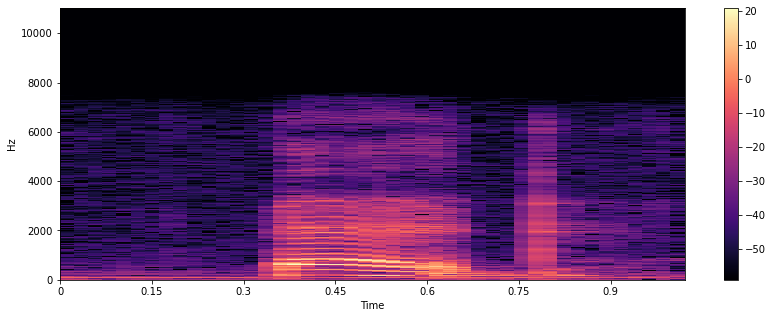

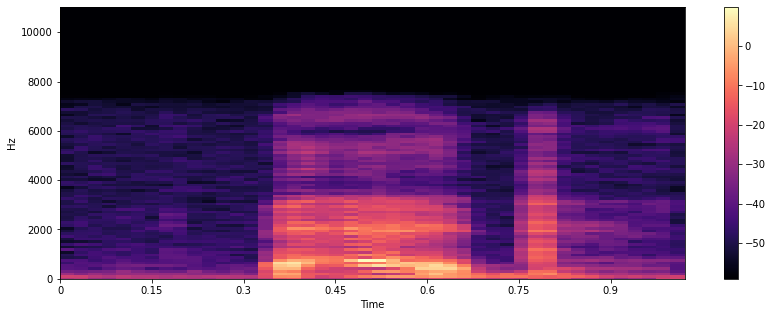

In [24]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
print(Xdb.shape)
print('\n')

'''Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()'''

X=Xdb
X = cv2.resize(X,(X.shape[1],X.shape[0]//10),interpolation = cv2.INTER_AREA)
plt.figure(figsize=(14, 5))
librosa.display.specshow(X, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
print(X.shape)
print('\n')

L'asse verticale mostra le frequenze (da 0 a 10kHz) e l'asse orizzontale mostra il tempo della clip. Poiché vediamo che tutte le azioni si svolgono nella parte inferiore dello spettro, possiamo convertire l'asse della frequenza in uno logaritmico.

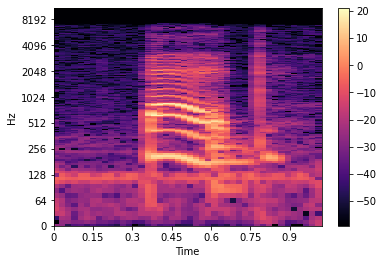

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

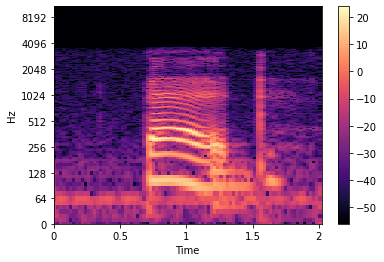

In [ ]:
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

#### Estrazione delle funzionalità da un segnale audio
Ogni segnale audio è costituito da molte funzionalità. Tuttavia, dobbiamo estrarre le caratteristiche che sono rilevanti per il problema che stiamo cercando di risolvere. Il processo di estrazione delle caratteristiche per utilizzarle per l'analisi è chiamato estrazione delle caratteristiche. Analizziamo in dettaglio alcune delle caratteristiche.

Le  caratteristiche spettrali  (basate sulla frequenza), che sono ottenute convertendo il segnale basato sul tempo nel dominio della frequenza mediante la trasformata di Fourier, come frequenza fondamentale, componenti di frequenza,  spettrale  centroide,  spectral  flusso,  spectral  densità  spettrale  roll-off, eccetera.

1. Centroide spettrale

Il  centroide spettrale  indica su quale frequenza è centrata l'energia di uno spettro o, in altre parole, indica dove si trova il "centro di massa" di un suono. Questo è come una media ponderata:

$$ f_c=\dfrac{\sum_{k}{S(k)f(k)}}{\sum_{k}{S(k)}} $$

dove S (k) è la grandezza spettrale alla frequenza bin k, f (k) è la frequenza al bin k.

librosa.feature.spectral_centroid calcola il centroide spettrale per ogni fotogramma in un segnale:

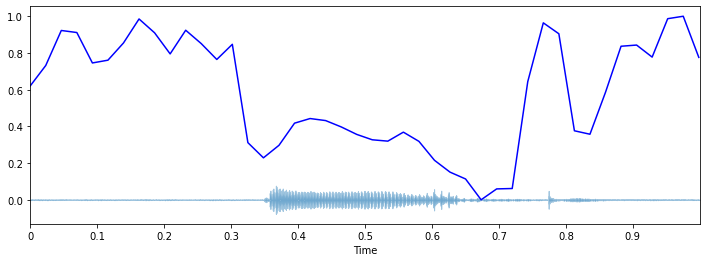

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

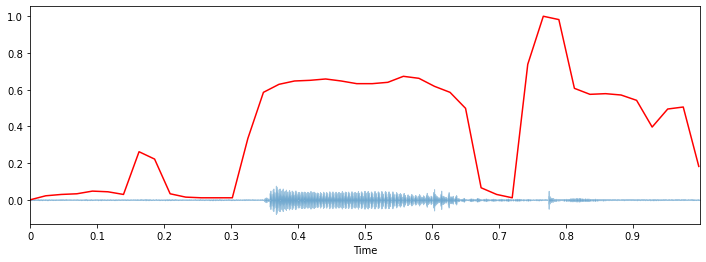

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

#### Spectral Bandwidth
La larghezza di banda spettrale è definita come l'ampiezza della banda di luce a metà del picco massimo (o l'intera larghezza a metà massimo [FWHM]) ed è rappresentata dalle due linee rosse verticali e λSB sull'asse delle lunghezze d'onda.
librosa.feature.spectral_bandwidth calcola la larghezza di banda spettrale di ordine-p:

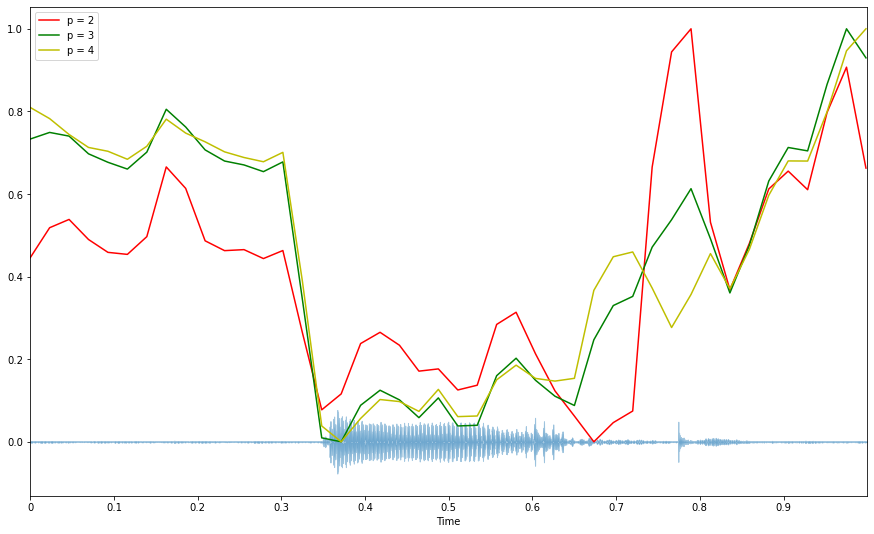

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

---
## Creazione dataset

Andiamo ora a creare il nostro dataset prelevando i file dalla directory. Possiamo recuperare le label di ogni audio prendendo il nome della cartella in cui i file sono contenuti.
Definiamo una funzione che prenda gli audio dalle cartelle e le salvi in una lista. La stessa funzione andrà a creare un dizionario contenente i valori unici delle etichette.
Purtroppo, a causa dell'elevato numero di elementi contenuti nel dataset e della limitate risorse di calcolo, sono stati prelevati solo 300 audio da ogni cartella (quindi 300 audio per classe, per un totale di 9000 audio).

In [14]:
def get_audio(directory):
    AudioMF=[]
    AudioWav=[]
    Labels=[]
    Spettri=[]
    sr=22050
    #definiamo un dizionario che andrà a contenere i tipi di etichette che abbiamo
    label_dict={}
    i=0
    cmap = plt.get_cmap('plasma')
    for cart in os.listdir(directory):
        #creiamo l'etichetta
        label=cart
        print("sto elaborando i file della cartella: ", cart)
        if label not in label_dict:
            label_dict[label]=i
            i=i+1 
        for wav in os.listdir(os.path.join(directory,cart))[:300]:
            aud=(os.path.join(directory,cart,wav))
            Labels.append(label_dict[label])
            y,_=librosa.load(aud,sr=sr)
            AudioWav.append(y)
            #parte spettrogramma
            Spettri.append(librosa.amplitude_to_db(abs(librosa.stft(y))))
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            AudioMF.append(mfcc)
    return (Spettri, AudioMF, AudioWav, Labels, label_dict)

In [15]:
SpettriA, AudioMF, AudioWav, Labels, label_dict =get_audio(dataset_dir)

sto elaborando i file della cartella:  right
sto elaborando i file della cartella:  eight
sto elaborando i file della cartella:  cat
sto elaborando i file della cartella:  tree
sto elaborando i file della cartella:  bed
sto elaborando i file della cartella:  happy
sto elaborando i file della cartella:  go
sto elaborando i file della cartella:  dog
sto elaborando i file della cartella:  no
sto elaborando i file della cartella:  wow
sto elaborando i file della cartella:  nine
sto elaborando i file della cartella:  left
sto elaborando i file della cartella:  stop
sto elaborando i file della cartella:  three
sto elaborando i file della cartella:  sheila
sto elaborando i file della cartella:  one
sto elaborando i file della cartella:  bird
sto elaborando i file della cartella:  zero
sto elaborando i file della cartella:  seven
sto elaborando i file della cartella:  up
sto elaborando i file della cartella:  marvin
sto elaborando i file della cartella:  two
sto elaborando i file della cartell

Contiamo quanti sono gli Audio e quante le etichette in modo da vedere se i 2 valori corrispondono:

Andiamo a vedere quanti valori unici abbiamo per le etichette:

In [17]:
label_dict

{'right': 0,
 'eight': 1,
 'cat': 2,
 'tree': 3,
 'bed': 4,
 'happy': 5,
 'go': 6,
 'dog': 7,
 'no': 8,
 'wow': 9,
 'nine': 10,
 'left': 11,
 'stop': 12,
 'three': 13,
 'sheila': 14,
 'one': 15,
 'bird': 16,
 'zero': 17,
 'seven': 18,
 'up': 19,
 'marvin': 20,
 'two': 21,
 'house': 22,
 'down': 23,
 'six': 24,
 'yes': 25,
 'on': 26,
 'five': 27,
 'off': 28,
 'four': 29}

Ricapitolando, abbiamo trovato le seguenti classi:
**bed**, **bird**, **cat**, **dog**, **down**, **eight**, **five**, **four**, **go**, **happy**, **house**, **left**, **marvin**, **nine**, **no**, **off**, **on**, **one**, **right**, **seven**, **sheila**, **six**, **stop**, **three**, **tree**, **two**, **up**, **wow**, **yes**, **zero**

## 2 - Preparazione dei dati

In questa sezione ci dedicheremo alla manipolazione del dataset al fine di condurre le nostre analisi. Andiamo a:
1. rendere uguali le dimensioni degli elementi contenuti nel dataset trovando l'elemento più grande e facendo padding sugli altri
2. flattenizzare le tuple del dataset
3. suddividere il dataset in *Train Set* e *Test Set*:

Iniziamo con la lista degli audio puri:

In [18]:
AudioWav=np.array(AudioWav)
#facciamo padding

max_len=max([len(x) for x in AudioWav])
AudioWavN=[]
for elem in AudioWav:
    n=max_len-len(elem)
    elem=np.pad(elem,(0,n), 'constant')
    AudioWavN.append(elem)
AudioWavN=np.array(AudioWavN)

Passiamo ora alla lista con le frequenze di Mel:

In [19]:
max_el=max([x.shape[1] for x in AudioMF])
AudioMFP=[]
for item in AudioMF:
    item = item.tolist()
    new_elem=[]
    for dim in item:
        dim.extend(np.zeros(max_el-len(dim)))
        new_elem.append(dim)
    AudioMFP.append(new_elem)
AudioMFP=np.array(AudioMFP)

Analizziamo ora la lista degli Spettri:

In [20]:
diz={}
for imm in SpettriA:
    shape = imm.shape
    if shape not in diz:
        diz[shape]=1
    else:
        diz[shape]+=1
print("numero di immagini di dimensione diversa: ",len(diz))
print(diz)

numero di immagini di dimensione diversa:  22
{(1025, 44): 8008, (1025, 32): 49, (1025, 39): 133, (1025, 41): 161, (1025, 26): 13, (1025, 37): 143, (1025, 43): 175, (1025, 35): 104, (1025, 34): 48, (1025, 30): 29, (1025, 31): 29, (1025, 33): 38, (1025, 28): 23, (1025, 24): 10, (1025, 29): 11, (1025, 27): 8, (1025, 21): 2, (1025, 40): 2, (1025, 25): 1, (1025, 42): 6, (1025, 36): 2, (1025, 23): 5}


Rendiamo le dimensioni delle immagini uguali per tutti gli elementi, utilizzando come riferimento le dimensioni che hanno in comune il maggior numero di spettri dividendola per un fattore 10.

In [21]:
#effettuiamo la resize degli elementi in SpettriA
Spettri=[]
for elem in SpettriA:
    Spettri.append(cv2.resize(elem,(103, 44)))
    
#flattening su spettrogrammi
Spettri=np.array(Spettri)
dataset_size=len(Spettri)
Spettri_F=Spettri.reshape(dataset_size,-1)

print ("Shape of Spettri: ", Spettri_F.shape)
print(Spettri_F[0].shape)

Shape of Spettri:  (9000, 4532)
(4532,)


Al fine di ridurre la dimensionalità dei dataset di Spettri e AudioWav, andiamo ad aplicare su essi la PCA. I dataset così ottenuti verranno salvati insieme a quelli AudioMFP e Labels.

In [23]:
pca=sklearn.decomposition.PCA(n_components=0.95)

In [24]:
AudioWavN=pca.fit_transform(AudioWavN)

In [25]:
with open(os.path.join(datasets,'AudioWavN.pkl'), 'wb') as file:
        pkl.dump(AudioWavN, file)
with open(os.path.join(modelli_dir,'pca_wav.pkl'), 'wb') as file:
        pkl.dump(pca, file)
with open(os.path.join(datasets,'AudioMFP.pkl'), 'wb') as file:
        pkl.dump(AudioMFP, file)       
with open(os.path.join(datasets,'Labels.pkl'), 'wb') as file:
        pkl.dump(Labels, file)

In [26]:
Spettri_F=pca.fit_transform(Spettri_F)

In [27]:
with open(os.path.join(datasets,'Spettri_F.pkl'), 'wb') as file:
        pkl.dump(Spettri_F, file)
with open(os.path.join(modelli_dir,'pca_spettri.pkl'), 'wb') as file:
        pkl.dump(pca, file)

Prendiamo i datasets dai file appena salvati

In [28]:
with open(os.path.join(datasets,'AudioWavN.pkl'), 'rb') as file:
        AudioWavN=pkl.load(file)

with open(os.path.join(datasets,'AudioMFP.pkl'), 'rb') as file:
        AudioMFP=pkl.load(file)

with open(os.path.join(datasets,'Spettri_F.pkl'), 'rb') as file:
        Spettri_F=pkl.load(file)
        
with open(os.path.join(datasets,'Labels.pkl'), 'rb') as file:
        Labels=pkl.load(file)

In [44]:
#flattenizziamo il dataset con le frequenze di mel per i classificatori normali
AudioMFP_F = np.array(AudioMFP.reshape(len(AudioMFP),-1))

Andiamo a creare un nuovo dataset concatenando quelli già esistenti:

In [30]:
AudioConc=np.concatenate([AudioWavN,AudioMFP_F,Spettri_F],axis=1)
print(AudioConc.shape)

(9000, 2970)


In [31]:
with open(os.path.join(datasets,'AudioConc.pkl'), 'wb') as file:
        pkl.dump(AudioConc, file)

In [32]:
with open(os.path.join(datasets,'AudioConc.pkl'), 'rb') as file:
        AudioConc=pkl.load(file)

Andiamo ora ad effettuare lo split dei vari dataset in train e test set per la classificazione con i modelli standard.

In [33]:
## split train / test

#Frequenze di Mel
x_train_mel, x_test_mel, y_train_mel, y_test_mel = train_test_split(AudioMFP_F, Labels, test_size=0.33, random_state=42)

print('Dimensioni training set: ',len(x_train_mel), len(y_train_mel))
print('Dimensioni validation set: ',len(x_test_mel), len(y_test_mel))

#Spettri
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(Spettri_F, Labels, test_size=0.33, random_state=42)

#Concatenazione Audio puri, frequenze di Mel e Spettri
x_train, x_test, y_train, y_test = train_test_split(AudioConc, Labels, test_size=0.33, random_state=42)


Dimensioni training set:  6030 6030
Dimensioni validation set:  2970 2970
Dimensioni training set:  6030 6030
Dimensioni validation set:  2970 2970
Dimensioni training set:  6030 6030
Dimensioni validation set:  2970 2970


## 4 - Classificazione

I classificatori che verranno utilizzati per i nostri scopi sono i seguenti:
* **K Nearest Neighbors**
* **Support Vector Machine**
* **Adaptive Boosting**

Per ogni classificatore andremo ad effettuare delle prove dandogli in input le diverse tipologie che abbiamo per i dati audio. Tutto ciò per vedere con quale di queste tipologie di dato avremo risultati migliori. In ordine avremo:
- Frequenze di Mel
- Spettri
- Dataset costituito dalla concatenazione degli audio puri, frequenze di Mel e Spettri

### KNN


Andiamo ad utilizzare il primo classificatore:

* **Frequenze di Mel**

Accuracy iterazione 0: 0.35888888888888887
Accuracy iterazione 1: 0.3333333333333333
Accuracy iterazione 2: 0.3477777777777778
Accuracy iterazione 3: 0.31444444444444447
Accuracy iterazione 4: 0.36
Accuracy iterazione 5: 0.3511111111111111
Accuracy iterazione 6: 0.31444444444444447
Accuracy iterazione 7: 0.3244444444444444
Accuracy iterazione 8: 0.35333333333333333
Accuracy iterazione 9: 0.33444444444444443
10-fold Accuracy= 0.3392222222222222
Accuracy = 0.31346801346801345
              precision    recall  f1-score   support

           0       0.19      0.35      0.25       103
           1       0.35      0.37      0.36       112
           2       0.21      0.33      0.26       100
           3       0.32      0.46      0.38        99
           4       0.10      0.22      0.13        96
           5       0.42      0.36      0.39       118
           6       0.09      0.26      0.13        85
           7       0.24      0.25      0.24       103
           8       0.15      0.20 

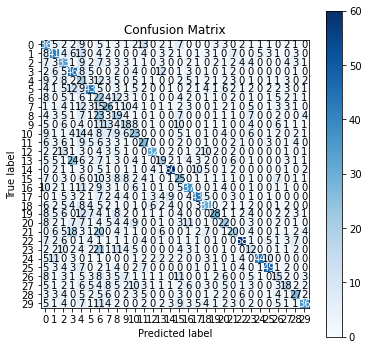

In [34]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train_mel, y_train_mel)
print("Accuracy =",knn.score(x_test_mel,y_test_mel))

y_pred_mel = knn.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred_mel))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred_mel,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'knn.pkl'), 'wb') as file:
        pkl.dump(knn, file)

* **Spettri**

Accuracy iterazione 0: 0.37333333333333335
Accuracy iterazione 1: 0.2833333333333333
Accuracy iterazione 2: 0.30444444444444446
Accuracy iterazione 3: 0.29888888888888887
Accuracy iterazione 4: 0.31444444444444447
Accuracy iterazione 5: 0.3422222222222222
Accuracy iterazione 6: 0.29
Accuracy iterazione 7: 0.29777777777777775
Accuracy iterazione 8: 0.3277777777777778
Accuracy iterazione 9: 0.2966666666666667
10-fold Accuracy= 0.3128888888888889
Accuracy = 0.26936026936026936
              precision    recall  f1-score   support

           0       0.17      0.33      0.23       103
           1       0.30      0.29      0.29       112
           2       0.22      0.30      0.25       100
           3       0.25      0.38      0.30        99
           4       0.11      0.23      0.14        96
           5       0.40      0.35      0.37       118
           6       0.07      0.18      0.10        85
           7       0.13      0.10      0.11       103
           8       0.09      0.16 

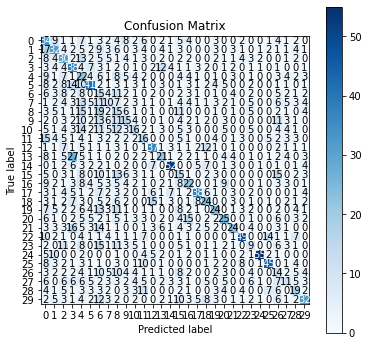

In [35]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, Spettri_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train_s, y_train_s)
print("Accuracy =",knn.score(x_test_s,y_test_s))

y_pred_s = knn.predict(x_test_s)
print(classification_report(y_test_s, y_pred_s))

skplt.metrics.plot_confusion_matrix(y_test_s,y_pred_s,figsize=(6,6))

* **Dataset costituito dalla concatenazione degli audio puri, frequenze di Mel e Spettri**

Accuracy iterazione 0: 0.35777777777777775
Accuracy iterazione 1: 0.3011111111111111
Accuracy iterazione 2: 0.32222222222222224
Accuracy iterazione 3: 0.3088888888888889
Accuracy iterazione 4: 0.3333333333333333
Accuracy iterazione 5: 0.3422222222222222
Accuracy iterazione 6: 0.3011111111111111
Accuracy iterazione 7: 0.3244444444444444
Accuracy iterazione 8: 0.3288888888888889
Accuracy iterazione 9: 0.31444444444444447
10-fold Accuracy= 0.3234444444444444
Accuracy = 0.29023569023569024
              precision    recall  f1-score   support

           0       0.20      0.35      0.25       103
           1       0.36      0.36      0.36       112
           2       0.20      0.30      0.24       100
           3       0.32      0.47      0.39        99
           4       0.11      0.24      0.15        96
           5       0.35      0.31      0.33       118
           6       0.08      0.24      0.12        85
           7       0.20      0.15      0.17       103
           8       0.1

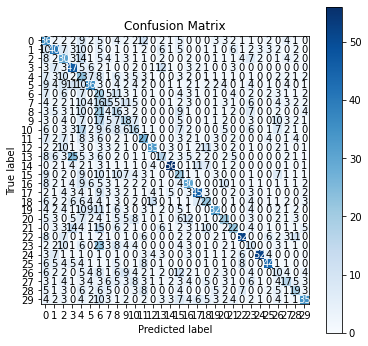

In [36]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, AudioConc, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train, y_train)
print("Accuracy =",knn.score(x_test,y_test))

y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

### SVM
Questo classificatore si fonda sull’idea di trovare un iperpiano che divida al meglio un set di dati in due classi, utilizzando allo scopo i seguenti passaggi:

* Cerca un iperpiano linearmente separabile o un limite di decisione che separa i valori di una classe dall’altro. Se ne esiste più di uno, cerca quello che ha margine più alto con i vettori di supporto, per migliorare l’accuratezza del modello.

* Se non dovesse trovare nulla con l'approccio lineare, SVM utilizza una mappatura non lineare per trasformare i dati di allenamento in una dimensione superiore. In questo modo, i dati di due classi possono sempre essere separati da un iperpiano, che sarà scelto per la suddivisione dei dati. 

Nelle celle seguenti verranno presentati questi due tipi di SVM, il primo mediante *linear SVM*, il secondo tramite *rbf SVM* e *polinomial SVM*.

NB: rbf sta per radial basis function.

* **Usiamo il dataset costituito dalle frequenze di Mel**

Accuracy iterazione 0: 0.4
Accuracy iterazione 1: 0.3888888888888889
Accuracy iterazione 2: 0.3377777777777778
Accuracy iterazione 3: 0.37
Accuracy iterazione 4: 0.3622222222222222
Accuracy iterazione 5: 0.3844444444444444
Accuracy iterazione 6: 0.33555555555555555
Accuracy iterazione 7: 0.33666666666666667
Accuracy iterazione 8: 0.35888888888888887
Accuracy iterazione 9: 0.3211111111111111
10-fold Accuracy= 0.3595555555555556
Accuracy = 0.31851851851851853
              precision    recall  f1-score   support

           0       0.34      0.12      0.17       103
           1       0.36      0.40      0.38       112
           2       0.25      0.26      0.25       100
           3       0.24      0.39      0.30        99
           4       0.21      0.27      0.24        96
           5       0.41      0.22      0.29       118
           6       0.16      0.29      0.21        85
           7       0.23      0.13      0.16       103
           8       0.23      0.12      0.15        

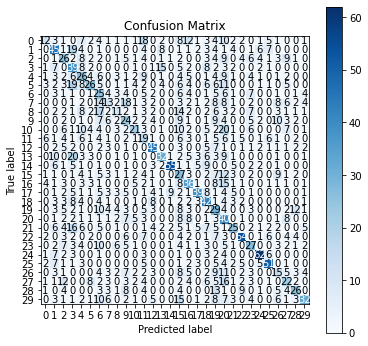

In [37]:
# rbf SVM

svm_rbf=SVC(kernel = 'rbf',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_rbf, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_rbf=svm_rbf.fit(x_train_mel,y_train_mel)
print("Accuracy =",svm_rbf.score(x_test_mel,y_test_mel))

y_pred = svm_rbf.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_rbf.pkl'), 'wb') as file:
        pkl.dump(svm_rbf, file)

Accuracy iterazione 0: 0.4444444444444444
Accuracy iterazione 1: 0.43222222222222223
Accuracy iterazione 2: 0.3811111111111111
Accuracy iterazione 3: 0.41333333333333333
Accuracy iterazione 4: 0.43
Accuracy iterazione 5: 0.44
Accuracy iterazione 6: 0.40555555555555556
Accuracy iterazione 7: 0.42
Accuracy iterazione 8: 0.4288888888888889
Accuracy iterazione 9: 0.41333333333333333
10-fold Accuracy= 0.42088888888888887
Accuracy = 0.4117845117845118
              precision    recall  f1-score   support

           0       0.32      0.38      0.35       103
           1       0.40      0.33      0.36       112
           2       0.34      0.36      0.35       100
           3       0.36      0.41      0.39        99
           4       0.33      0.33      0.33        96
           5       0.55      0.48      0.52       118
           6       0.28      0.32      0.30        85
           7       0.26      0.26      0.26       103
           8       0.33      0.36      0.35        95
         

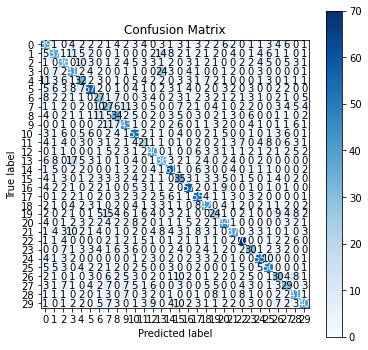

In [38]:
# linear SVM

svm_linear=SVC(kernel = 'linear',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_linear, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_linear=svm_linear.fit(x_train_mel,y_train_mel)
print("Accuracy =",svm_linear.score(x_test_mel,y_test_mel))

y_pred = svm_linear.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_linear.pkl'), 'wb') as file:
        pkl.dump(svm_linear, file)

Accuracy iterazione 0: 0.3888888888888889
Accuracy iterazione 1: 0.4166666666666667
Accuracy iterazione 2: 0.3622222222222222
Accuracy iterazione 3: 0.4122222222222222
Accuracy iterazione 4: 0.39111111111111113
Accuracy iterazione 5: 0.41
Accuracy iterazione 6: 0.3522222222222222
Accuracy iterazione 7: 0.35555555555555557
Accuracy iterazione 8: 0.39444444444444443
Accuracy iterazione 9: 0.3711111111111111
10-fold Accuracy= 0.3854444444444444
Accuracy = 0.3451178451178451
              precision    recall  f1-score   support

           0       0.36      0.12      0.18       103
           1       0.49      0.30      0.37       112
           2       0.23      0.33      0.27       100
           3       0.25      0.55      0.34        99
           4       0.31      0.28      0.29        96
           5       0.52      0.22      0.31       118
           6       0.22      0.28      0.24        85
           7       0.28      0.13      0.17       103
           8       0.29      0.11    

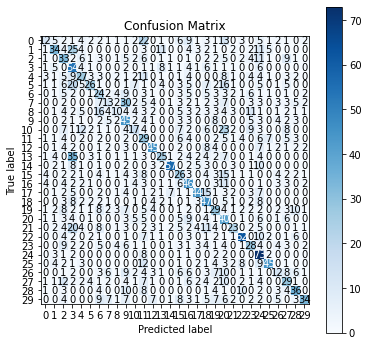

In [39]:
# polinomial SVM

svm_poly=SVC(kernel = 'poly',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_poly, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_poly=svm_poly.fit(x_train_mel,y_train_mel)
print("Accuracy =",svm_poly.score(x_test_mel,y_test_mel))

y_pred = svm_poly.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_poly.pkl'), 'wb') as file:
        pkl.dump(svm_poly, file)

Prendendo in considerazione i risultati delle analisi effettuate con entrabi i tipi di SVM possiamo concludere che il migliore sia quello ottenuto con l'SVM di tipo lineare.

### ADABOOST
Il classificatore AdaBoost (Adaptive Boosting) fa parte della famiglia di algoritmi di boosting, che permettono di combinare più classificatori deboli in un unico classificatore forte.
Il Boosting è un metodo di ensemble per migliorare le previsioni del modello di un determinato algoritmo di apprendimento. L’idea che ne è alla base è quella di formare sequenzialmente weak learner, ognuno cercando di correggere il suo predecessore.

Questo viene fatto creando prima un modello dai dati di addestramento, in seguito viene creato un secondo modello che tenta di correggere gli errori dal primo modello.

I modelli vengono aggiunti fino a quando il set di addestramento non viene previsto perfettamente o non viene aggiunto un numero massimo di modelli.

* **Frequenze di Mel**

Accuracy iterazione 0: 0.2477777777777778
Accuracy iterazione 1: 0.21666666666666667
Accuracy iterazione 2: 0.21666666666666667
Accuracy iterazione 3: 0.24666666666666667
Accuracy iterazione 4: 0.26
Accuracy iterazione 5: 0.26
Accuracy iterazione 6: 0.2222222222222222
Accuracy iterazione 7: 0.23666666666666666
Accuracy iterazione 8: 0.24888888888888888
Accuracy iterazione 9: 0.24333333333333335
10-fold Accuracy= 0.23988888888888887
Accuracy = 0.2138047138047138
              precision    recall  f1-score   support

           0       0.20      0.21      0.20       103
           1       0.29      0.24      0.26       112
           2       0.13      0.14      0.14       100
           3       0.24      0.25      0.25        99
           4       0.15      0.16      0.15        96
           5       0.37      0.37      0.37       118
           6       0.08      0.11      0.09        85
           7       0.21      0.19      0.20       103
           8       0.08      0.08      0.08    

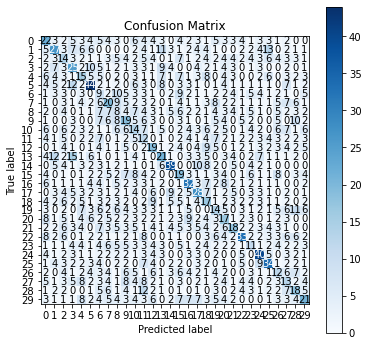

In [40]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.5, n_estimators=15)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(AdaBoost, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()
print(f"10-fold Accuracy= {train_score}")

AdaBoost=AdaBoost.fit(x_train_mel,y_train_mel)
print("Accuracy =",AdaBoost.score(x_test_mel,y_test_mel))

y_pred_mel = AdaBoost.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred_mel))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred_mel,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AdaBoost.pkl'), 'wb') as file:
        pkl.dump(AdaBoost, file)

* **Spettri**

Accuracy iterazione 0: 0.16333333333333333
Accuracy iterazione 1: 0.1622222222222222
Accuracy iterazione 2: 0.12333333333333334
Accuracy iterazione 3: 0.1411111111111111
Accuracy iterazione 4: 0.16555555555555557
Accuracy iterazione 5: 0.1688888888888889
Accuracy iterazione 6: 0.14666666666666667
Accuracy iterazione 7: 0.17222222222222222
Accuracy iterazione 8: 0.1711111111111111
Accuracy iterazione 9: 0.16666666666666666
10-fold Accuracy= 0.15811111111111112
Accuracy = 0.1595959595959596
              precision    recall  f1-score   support

           0       0.08      0.09      0.08       103
           1       0.24      0.20      0.22       112
           2       0.08      0.09      0.08       100
           3       0.13      0.14      0.14        99
           4       0.09      0.09      0.09        96
           5       0.16      0.14      0.15       118
           6       0.11      0.14      0.12        85
           7       0.12      0.11      0.11       103
           8       

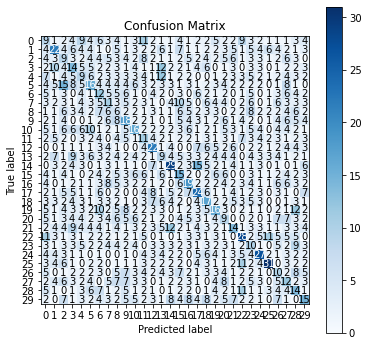

In [41]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.5, n_estimators=15)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(AdaBoost, Spettri_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()
print(f"10-fold Accuracy= {train_score}")

AdaBoost=AdaBoost.fit(x_train_s,y_train_s)
print("Accuracy =",AdaBoost.score(x_test_s,y_test_s))

y_pred_s = AdaBoost.predict(x_test_s)
print(classification_report(y_test_s, y_pred_s))

skplt.metrics.plot_confusion_matrix(y_test_s,y_pred_s,figsize=(6,6))

* **Dataset costituito dalla concatenazione degli audio puri, frequenze di Mel e Spettri**

Accuracy iterazione 0: 0.20555555555555555
Accuracy iterazione 1: 0.2288888888888889
Accuracy iterazione 2: 0.19333333333333333
Accuracy iterazione 3: 0.19555555555555557
Accuracy iterazione 4: 0.22666666666666666
Accuracy iterazione 5: 0.2388888888888889
Accuracy iterazione 6: 0.1988888888888889
Accuracy iterazione 7: 0.1922222222222222
Accuracy iterazione 8: 0.20333333333333334
Accuracy iterazione 9: 0.20666666666666667
10-fold Accuracy= 0.209
Accuracy = 0.18585858585858586
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       103
           1       0.28      0.21      0.24       112
           2       0.11      0.10      0.10       100
           3       0.19      0.24      0.21        99
           4       0.09      0.09      0.09        96
           5       0.27      0.25      0.26       118
           6       0.03      0.04      0.03        85
           7       0.17      0.14      0.15       103
           8       0.09      0.1

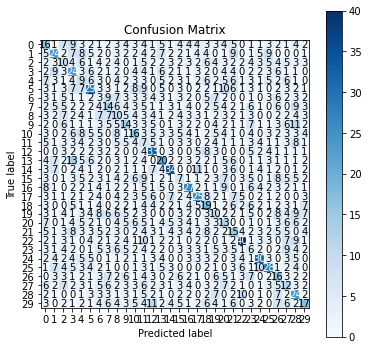

In [42]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.5, n_estimators=15)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(AdaBoost, AudioConc, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()
print(f"10-fold Accuracy= {train_score}")

AdaBoost=AdaBoost.fit(x_train,y_train)
print("Accuracy =",AdaBoost.score(x_test,y_test))

y_pred = AdaBoost.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

## Rete Neurale
Una rete neurale convoluzionale funziona, in generale, come tutte le altre feed forward. Essa infatti è costituita da  un blocco di input, uno o più blocchi nascosti (hidden layer), che effettuano calcoli tramite funzioni di attivazione (ad esempio RELU)  e un blocco di output che effettua la classificazione vera e propria. La differenza, infatti,  rispetto alle classiche reti feed forward è rappresentata dalla presenza dei livelli di convoluzione.

Per Utilizzare le reti neurali dobbiamo prendere il dataset contenente le frequenze di Mel non flattenizzate.

In [58]:
## split train / test

x_train_nn,x_test_nn,y_train_nn,y_test_nn=train_test_split(AudioMFP,Labels,train_size=0.80, test_size=0.20)

#aggiungiamo un'altra dimensione relativa alla gray-scale
x_train_nn = np.expand_dims(x_train_nn,axis=3)
x_test_nn = np.expand_dims(x_test_nn,axis=3)
y_train_nn,y_test_nn = np.array(y_train_nn),np.array(y_test_nn)

print('Dimensioni training set: ',len(x_train_nn), len(y_train_nn))
print('Dimensioni validation set: ',len(x_test_nn), len(y_test_nn))

Dimensioni training set:  7200 7200
Dimensioni validation set:  1800 1800


Effettuiamo delle prove con due reti neurali differenti e per ognuna di esse andremo anche a fare 10-fold cross validation

### PRIMA RETE NEURALE

In [59]:
model = Sequential()
input_shape=(20, 44, 1)#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))#Output layer
model.add(Dense(30))
model.add(Activation('softmax'))
model.summary()

model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#Epoche: 100
reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.2, min_lr=1e-25)
history = model.fit(x_train_nn, y_train_nn, batch_size=128, epochs=100, verbose=1, callbacks=[reduce_lr])

test_loss = model.evaluate(x_test_nn,y_test_nn)

#salvataggio del modello
tf.keras.models.save_model(model,os.path.join(modelli_dir,'CNN'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 9, 21, 32)         320       
_________________________________________________________________
average_pooling2d_9 (Average (None, 4, 10, 32)         0         
_________________________________________________________________
activation_17 (Activation)   (None, 4, 10, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 10, 64)         18496     
_________________________________________________________________
average_pooling2d_10 (Averag (None, 2, 5, 64)          0         
_________________________________________________________________
activation_18 (Activation)   (None, 2, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 5, 64)         

Vediamo i valori che ci interessano maggiormente accuracy e precision. Mostriamo, inoltre, il grafico di accuracy e loss:

Accuratezza: 0.02222222276031971
Precision on test set:  0.03670762358819841


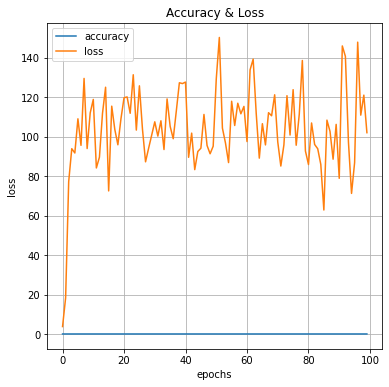

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

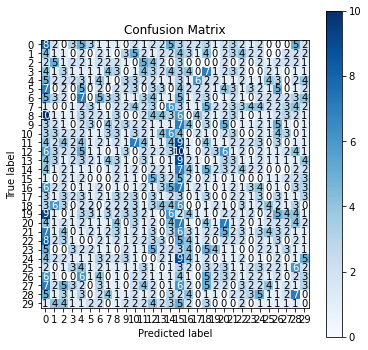

In [60]:
#Accuracy
print( "Accuratezza:" ,test_loss[1])

# Precision
y_pred_nn = model.predict_classes(x_test_nn)
print('Precision on test set: ', metrics.precision_score(y_test_nn, y_pred_nn, average='weighted'))

#Grafico di accuratezza e loss
plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Accuracy & Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()


skplt.metrics.plot_confusion_matrix(y_test_nn, y_pred_nn, figsize=(6,6))

Andiamo ora testare il nostro modello con 10-fold cross validation effettuando nuovamente il passaggio di splitting del dataset in Train e Test set

In [61]:
# Configurazione del modello
num_folds = 10

fold_accuracy = []
fold_loss = []

inputs = np.expand_dims(AudioMFP,axis=3)
targets = np.array(Labels)

#Definizione del K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [62]:
fold_count = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    input_shape=(20, 44, 1)#1st hidden layer
    model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
    model.add(AveragePooling2D((2, 2), strides=(2,2)))
    model.add(Activation('relu'))#2nd hidden layer
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(AveragePooling2D((2, 2), strides=(2,2)))
    model.add(Activation('relu'))#3rd hidden layer
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(AveragePooling2D((2, 2), strides=(2,2)))
    model.add(Activation('relu'))#Flatten
    model.add(Flatten())
    model.add(Dropout(rate=0.5))#Add fully connected layer.
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))#Output layer
    model.add(Dense(30))
    model.add(Activation('softmax'))
    model.summary()
    
    # Compilazione del modello
    model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    #Epoche: 100
    print(f'Training iterazione {fold_count} ...')

    # Adattamento dei dati al modello
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.2, min_lr=1e-25)
    history1 = model.fit(inputs[train], targets[train], batch_size=128, epochs=100, verbose=1, callbacks=[reduce_lr])

    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    fold_accuracy.append(scores[1] * 100)
    fold_loss.append(scores[0])

    # Passaggio alla  fold successiva
    fold_count = fold_count + 1

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 9, 21, 32)         320       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 4, 10, 32)         0         
_________________________________________________________________
activation_22 (Activation)   (None, 4, 10, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 10, 64)         18496     
_________________________________________________________________
average_pooling2d_13 (Averag (None, 2, 5, 64)          0         
_________________________________________________________________
activation_23 (Activation)   (None, 2, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 5, 64)         

Andiamo a visulizzare i risultati ottenuti mostrando i valori di accuracy e di loss per ogni fold:

In [63]:
for i in range(0, len(fold_accuracy)):
    print(f'Fold {i+1}  - Accuracy: {fold_accuracy[i]}  ----  Loss: {fold_loss[i]}')   
print('Average scores totali:')
print(f' Accuracy: {np.mean(fold_accuracy)}  ----  Loss: {np.mean(fold_loss)}')

Fold 1  - Accuracy: 3.5555556416511536  ----  Loss: 3.403987407684326
Fold 2  - Accuracy: 1.7777778208255768  ----  Loss: 3.404261827468872
Fold 3  - Accuracy: 2.1111110225319862  ----  Loss: 3.403391122817993
Fold 4  - Accuracy: 2.1111110225319862  ----  Loss: 3.4025394916534424
Fold 5  - Accuracy: 2.333333343267441  ----  Loss: 3.4023852348327637
Fold 6  - Accuracy: 2.777777798473835  ----  Loss: 3.4038279056549072
Fold 7  - Accuracy: 3.777777776122093  ----  Loss: 3.402087688446045
Fold 8  - Accuracy: 2.9999999329447746  ----  Loss: 3.4028916358947754
Fold 9  - Accuracy: 2.333333343267441  ----  Loss: 3.4042491912841797
Fold 10  - Accuracy: 2.333333343267441  ----  Loss: 3.4041168689727783
Average scores totali:
 Accuracy: 2.611111104488373  ----  Loss: 3.4033738374710083


### SECONDA RETE NEURALE

Valutazione dei risultati di un'altra rete neurale:

In [64]:
#CNN

model = Sequential()
model.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (20, 44, 1)))
model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))
model.add(GlobalAveragePooling2D())
model.add(Dense(300, activation="relu", name='rl'))
model.add(Dropout(0.5))
model.add(Dense(30,activation='softmax', name='sm'))
model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#Epoche: 100
reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.2, min_lr=1e-25)
history = model.fit(x_train_nn, y_train_nn, batch_size=128, epochs=100, verbose=1, callbacks=[reduce_lr])

test_loss = model.evaluate(x_test_nn,y_test_nn)

#salvataggio del modello
tf.keras.models.save_model(model,os.path.join(modelli_dir,'CNN'))

Epoch 1/100
57/57 [==============================] - 1s 20ms/step - loss: 3.4030 - accuracy: 0.0425
Epoch 2/100
57/57 [==============================] - 1s 20ms/step - loss: 3.2967 - accuracy: 0.0673
Epoch 3/100
57/57 [==============================] - 1s 20ms/step - loss: 3.1959 - accuracy: 0.0928
Epoch 4/100
57/57 [==============================] - 1s 20ms/step - loss: 3.0918 - accuracy: 0.1194
Epoch 5/100
57/57 [==============================] - 1s 21ms/step - loss: 3.0277 - accuracy: 0.1299
Epoch 6/100
57/57 [==============================] - 1s 21ms/step - loss: 2.9254 - accuracy: 0.1505
Epoch 7/100
57/57 [==============================] - 1s 20ms/step - loss: 2.8782 - accuracy: 0.1580
Epoch 8/100
57/57 [==============================] - 1s 21ms/step - loss: 2.8109 - accuracy: 0.1809
Epoch 9/100
57/57 [==============================] - 1s 21ms/step - loss: 2.7556 - accuracy: 0.1902
Epoch 10/100
57/57 [==============================] - 1s 21ms/step - loss: 2.7134 - accuracy: 0.2089

Vediamo i valori che ci interessano maggiormente accuracy e precision. Mostriamo, inoltre, il grafico di accuracy e loss:

Accuratezza: 0.7105555534362793
Precision on test set:  0.03922953626476411


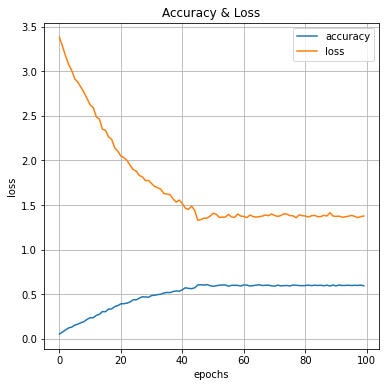

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

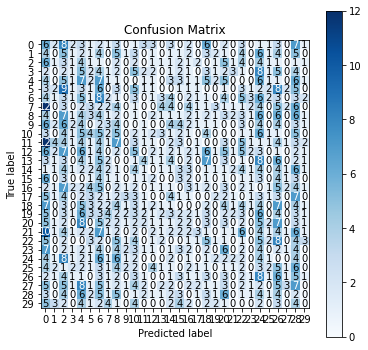

In [65]:
#Accuracy
print( "Accuratezza:" ,test_loss[1])

# Precision
y_pred_nn = model.predict_classes(x_test_nn)
print('Precision on test set: ', metrics.precision_score(y_test_nn, y_pred_nn, average='weighted'))

#Grafico di accuratezza e loss
plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Accuracy & Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()


skplt.metrics.plot_confusion_matrix(y_test_nn, y_pred_nn, figsize=(6,6))

Andiamo ora testare il nostro modello con 10-fold cross validation effettuando nuovamente il passaggio di splitting del dataset in Train e Test set

In [66]:
# Configurazione del modello
num_folds = 10

fold_accuracy = []
fold_loss = []

inputs = np.expand_dims(AudioMFP,axis=3)
targets = np.array(Labels)

#Definizione del K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [67]:
fold_count = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (20, 44, 1)))
    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(300, activation="relu", name='rl'))
    model.add(Dropout(0.5))
    model.add(Dense(30,activation='softmax', name='sm'))
    # Compilazione del modello
    model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Training iterazione {fold_count} ...')

    # Adattamento dei dati al modello
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.2, min_lr=1e-25)
    history1 = model.fit(inputs[train], targets[train], batch_size=128, epochs=10, verbose=1, callbacks=[reduce_lr])

    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    fold_accuracy.append(scores[1] * 100)
    fold_loss.append(scores[0])

    # Passaggio alla  fold successiva
    fold_count = fold_count + 1

Training iterazione 1 ...
Epoch 1/10
64/64 [==============================] - 2s 20ms/step - loss: 3.4018 - accuracy: 0.0392
Epoch 2/10
64/64 [==============================] - 1s 20ms/step - loss: 3.2970 - accuracy: 0.0728
Epoch 3/10
64/64 [==============================] - 1s 20ms/step - loss: 3.1652 - accuracy: 0.0973
Epoch 4/10
64/64 [==============================] - 1s 20ms/step - loss: 3.1011 - accuracy: 0.1131
Epoch 5/10
64/64 [==============================] - 1s 21ms/step - loss: 2.9976 - accuracy: 0.1361
Epoch 6/10
64/64 [==============================] - 1s 20ms/step - loss: 2.9192 - accuracy: 0.1545
Epoch 7/10
64/64 [==============================] - 1s 21ms/step - loss: 2.8235 - accuracy: 0.1778
Epoch 8/10
64/64 [==============================] - 1s 21ms/step - loss: 2.7643 - accuracy: 0.1831
Epoch 9/10
64/64 [==============================] - 1s 20ms/step - loss: 2.6809 - accuracy: 0.2139
Epoch 10/10
64/64 [==============================] - 1s 21ms/step - loss: 2.5864 - 

Andiamo a visulizzare i risultati ottenuti mostrando i valori di accuracy e di loss per ogni fold:

In [68]:
for i in range(0, len(fold_accuracy)):
    print(f'Fold {i+1}  - Accuracy: {fold_accuracy[i]}  ----  Loss: {fold_loss[i]}')   
print('Average scores totali:')
print(f' Accuracy: {np.mean(fold_accuracy)}  ----  Loss: {np.mean(fold_loss)}')

Fold 1  - Accuracy: 31.666666269302368  ----  Loss: 2.332916498184204
Fold 2  - Accuracy: 27.222222089767456  ----  Loss: 2.446826934814453
Fold 3  - Accuracy: 28.00000011920929  ----  Loss: 2.4526994228363037
Fold 4  - Accuracy: 31.777778267860413  ----  Loss: 2.262789011001587
Fold 5  - Accuracy: 25.66666603088379  ----  Loss: 2.453551769256592
Fold 6  - Accuracy: 31.777778267860413  ----  Loss: 2.345867872238159
Fold 7  - Accuracy: 29.555556178092957  ----  Loss: 2.356980323791504
Fold 8  - Accuracy: 34.00000035762787  ----  Loss: 2.3485488891601562
Fold 9  - Accuracy: 33.444443345069885  ----  Loss: 2.2461729049682617
Fold 10  - Accuracy: 32.88888931274414  ----  Loss: 2.2659506797790527
Average scores totali:
 Accuracy: 30.600000023841858  ----  Loss: 2.351230430603027


## 5 - Anomaly Detection
Il processo di Anomaly Detection consiste nel riconoscimento di condizioni o circostanze inaspettate (ovvero qualcosa che differisce dalla norma) all’interno di un dataset. Parleremo di Anomaly Detection semi-supervisionato ovvero quando una piccola porzione di istanze del dataset viene fornita etichettata mentre il resto dei dati senza etichette.
Il training set sarà composto dalla classe più numerosa del dataset.
Per questa fase andiamo ad utilizzare il dataset delle frequenze di Mel flattenizzato.

In [69]:
# vediamo qual è la classa più numerosa
max_class=pd.Series(Labels).value_counts().index[0]
normal=[] #audio normali, ovvero tutte quelle della max_class
lab=[] # label nomali (1)
a_lab=[] #label anomali (-1)  
anomaly=[] #audio anormali, ovvero tutte le rimanenti presenti nelle altre classi
c=0
for i in AudioMFP_F: 
    if Labels[c]==max_class:
        normal.append(i)
        lab.append(1)
    else:
        anomaly.append(i)
        a_lab.append(-1)
    c+=1

normal = np.array(normal)
anomaly = np.array(anomaly)
norm_labels = np.array(lab, dtype='int32')
anom_labels = np.array(a_lab, dtype='int32')

In [70]:
normal.shape

(300, 880)

Si considera come anomalie tutte le immagini presenti nelle cartelle: "belts", "sports_shoes" e "wallets".

In [71]:
x_train_ad, x_test_ad, y_train_ad, y_test_ad = train_test_split(normal, norm_labels, test_size=0.3, random_state=42)

test_set = np.append(x_test_ad, anomaly, axis=0)
test_labels = np.append(y_test_ad, anom_labels)

# ONE CLASS SVM
ocsvm = OneClassSVM(gamma=0.0001, kernel='rbf', nu=0.1).fit(x_train_ad)


y_pred_ad = ocsvm.predict(x_train_ad)
a_pred = ocsvm.predict(anomaly)

pred = np.append(y_pred_ad, a_pred)
t_labels = np.append(y_train_ad, anom_labels)

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AnDetOCSVM.pkl'), 'wb') as file:
        pkl.dump(ocsvm, file)

In [72]:
print(classification_report(t_labels, pred))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      8700
           1       1.00      0.38      0.55       210

    accuracy                           0.99      8910
   macro avg       0.99      0.69      0.77      8910
weighted avg       0.99      0.99      0.98      8910



Per valutare il detector facciamo uso delle **curve di ROC**.
La curva ROC viene costruita considerando tutti i possibili valori del test e, per ognuno di questi, calcola la proporzione di veri positivi e la proporzione di falsi positivi. Congiungendo i punti che mettono in rapporto la proporzione di veri positivi e di falsi positivi (le cosiddette coordinate) si ottiene una curva chiamata, appunto, **curva ROC**. L’area sottostante alla curva ROC (AUC, acronimo dei termini inglesi “Area Under the Curve”) è una misura di accuratezza.

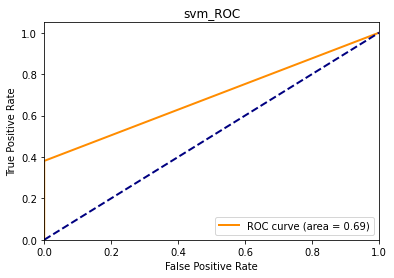

In [73]:
# Calcola la curva ROC e l'area ROC per le previsioni sul set di convalida
fpr, tpr, _ = roc_curve(t_labels, pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('svm_ROC')
plt.legend(loc="lower right")
plt.show()

L’area sotto la curva può assumere valori compresi tra 0.5 e 1.0. Tanto maggiore è l’area sotto la curva (cioè tanto più la curva si avvicina al vertice del grafico) tanto maggiore è il potere discriminante del test. Per l’interpretazione dei valori dell’area sottostante la curva ROC se si ha:
1. AUC=0.5 il test non è informativo;
2. 0.5<AUC≤0.7 il test è poco accurato;
3. 0.7<AUC≤0.9 il test è moderatamente accurato;
4. 0.9<AUC<1.0 il test è altamente accurato;
5. AUC=1 test perfetto.

Nel nostro caso l'area risulta 0.69 e quindi il test risulta poco accurato.

Proviamo ad utilizzare un altro algoritmo per la classificazione:

In [74]:
x_train_ad, x_test_ad, y_train_ad, y_test_ad = train_test_split(normal, norm_labels, test_size=0.3, random_state=42)

test_set = np.append(x_test_ad, anomaly, axis=0)
test_labels = np.append(y_test_ad, anom_labels)

#ensemble.IsolationForest
Iso_f = IsolationForest( n_estimators=500, random_state=0).fit(x_train_ad)


y_pred_ad = Iso_f.predict(x_train_ad)
a_pred = Iso_f.predict(anomaly)

pred = np.append(y_pred_ad, a_pred)
t_labels = np.append(y_train_ad, anom_labels)

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AnDetIsolationForest.pkl'), 'wb') as file:
        pkl.dump(Iso_f, file)

In [75]:
print(classification_report(t_labels, pred))

              precision    recall  f1-score   support

          -1       0.98      0.02      0.04      8700
           1       0.02      0.99      0.05       210

    accuracy                           0.04      8910
   macro avg       0.50      0.50      0.04      8910
weighted avg       0.96      0.04      0.04      8910



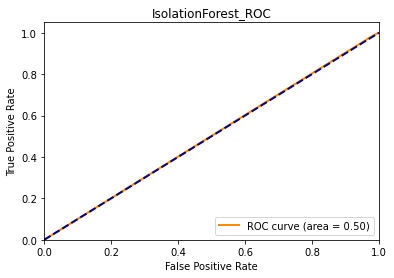

In [76]:
# Calcola la curva ROC e l'area ROC per le previsioni sul set di convalida
fpr, tpr, _ = roc_curve(t_labels, pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('IsolationForest_ROC')
plt.legend(loc="lower right")
plt.show()

Nel nostro caso l'area risulta 0.50 e quindi il test non è informativo.

In [77]:
x_train_ad, x_test_ad, y_train_ad, y_test_ad = train_test_split(normal, norm_labels, test_size=0.3, random_state=42)

test_set = np.append(x_test_ad, anomaly, axis=0)
test_labels = np.append(y_test_ad, anom_labels)

#LocalOutlierFactor
LocalOutFact = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, contamination='auto', novelty=True).fit(x_train_ad)


y_pred_ad = LocalOutFact.predict(x_train_ad)
a_pred = LocalOutFact.predict(anomaly)

pred = np.append(y_pred_ad, a_pred)
t_labels = np.append(y_train_ad, anom_labels)

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AnDetLocalOutFact.pkl'), 'wb') as file:
        pkl.dump(LocalOutFact, file)

In [78]:
print(classification_report(t_labels, pred))

              precision    recall  f1-score   support

          -1       0.97      0.00      0.01      8700
           1       0.02      1.00      0.05       210

    accuracy                           0.03      8910
   macro avg       0.50      0.50      0.03      8910
weighted avg       0.95      0.03      0.01      8910



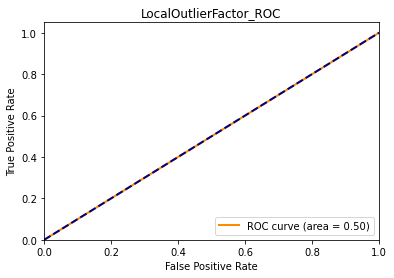

In [79]:
# Calcola la curva ROC e l'area ROC per le previsioni sul set di convalida
fpr, tpr, _ = roc_curve(t_labels, pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LocalOutlierFactor_ROC')
plt.legend(loc="lower right")
plt.show()

Nel nostro caso l'area risulta 0.50 e quindi il test non è informativo.

# Classificazione su dataset completo

Mostriamo di seguito i risultati ottenuti sul dataset completo. Purtroppo, per la poca potenza di calcolo a disposizione, questi sono i classificatori che sono stati eseguiti.

### KNN


Andiamo ad utilizzare il primo classificatore:

* **Frequenze di Mel**

Accuracy iterazione 0: 0.5145865699982738
Accuracy iterazione 1: 0.5059554634904194
Accuracy iterazione 2: 0.523045054375971
Accuracy iterazione 3: 0.5134668508287292
Accuracy iterazione 4: 0.5234806629834254
Accuracy iterazione 5: 0.5089779005524862
Accuracy iterazione 6: 0.506042817679558
Accuracy iterazione 7: 0.5013812154696132
Accuracy iterazione 8: 0.5132941988950276
Accuracy iterazione 9: 0.5108770718232044
10-fold Accuracy= 0.5121107806096709
Accuracy = 0.4770599006016218
              precision    recall  f1-score   support

           0       0.34      0.49      0.40       697
           1       0.58      0.62      0.60       720
           2       0.34      0.40      0.37       513
           3       0.48      0.49      0.49       562
           4       0.18      0.37      0.24       483
           5       0.60      0.56      0.58       515
           6       0.21      0.40      0.28       697
           7       0.28      0.32      0.30       519
           8       0.25     

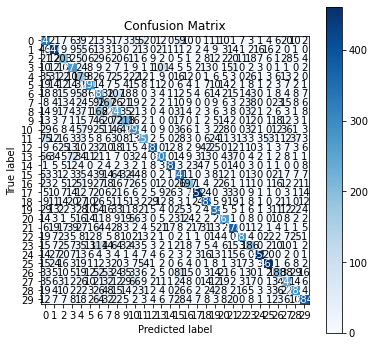

In [7]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train_mel, y_train_mel)
print("Accuracy =",knn.score(x_test_mel,y_test_mel))

y_pred_mel = knn.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred_mel))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred_mel,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'knn.pkl'), 'wb') as file:
        pkl.dump(knn, file)

* **Spettri**

Accuracy iterazione 0: 0.444847229414811
Accuracy iterazione 1: 0.448817538408424
Accuracy iterazione 2: 0.46279993095114796
Accuracy iterazione 3: 0.457182320441989
Accuracy iterazione 4: 0.45683701657458564
Accuracy iterazione 5: 0.4431975138121547
Accuracy iterazione 6: 0.4257596685082873
Accuracy iterazione 7: 0.44388812154696133
Accuracy iterazione 8: 0.44129834254143646
Accuracy iterazione 9: 0.44665055248618785
10-fold Accuracy= 0.44712782346859853
Accuracy = 0.41778707821082917
              precision    recall  f1-score   support

           0       0.32      0.49      0.39       697
           1       0.53      0.54      0.54       720
           2       0.33      0.38      0.36       513
           3       0.45      0.45      0.45       562
           4       0.14      0.31      0.19       483
           5       0.49      0.48      0.48       515
           6       0.18      0.37      0.24       697
           7       0.22      0.23      0.22       519
           8       0.2

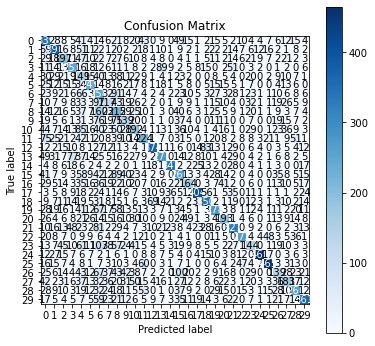

In [9]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, Spettri_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train_s, y_train_s)
print("Accuracy =",knn.score(x_test_s,y_test_s))

y_pred_s = knn.predict(x_test_s)
print(classification_report(y_test_s, y_pred_s))

skplt.metrics.plot_confusion_matrix(y_test_s,y_pred_s,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'knn.pkl'), 'wb') as file:
        pkl.dump(knn, file)

* **Dataset costituito dalla concatenazione degli audio puri, frequenze di Mel e Spettri**

Accuracy iterazione 0: 0.4918004488175384
Accuracy iterazione 1: 0.4905920939064388
Accuracy iterazione 2: 0.5038839979285344
Accuracy iterazione 3: 0.4993093922651934
Accuracy iterazione 4: 0.5048342541436464
Accuracy iterazione 5: 0.4932665745856354
Accuracy iterazione 6: 0.4796270718232044
Accuracy iterazione 7: 0.48204419889502764
Accuracy iterazione 8: 0.48549723756906077
Accuracy iterazione 9: 0.49620165745856354
10-fold Accuracy= 0.4927056927392843
Accuracy = 0.4611561600837039
              precision    recall  f1-score   support

           0       0.34      0.51      0.41       697
           1       0.55      0.61      0.58       720
           2       0.35      0.39      0.37       513
           3       0.49      0.49      0.49       562
           4       0.15      0.33      0.21       483
           5       0.59      0.52      0.55       515
           6       0.20      0.39      0.27       697
           7       0.25      0.28      0.27       519
           8       0.24

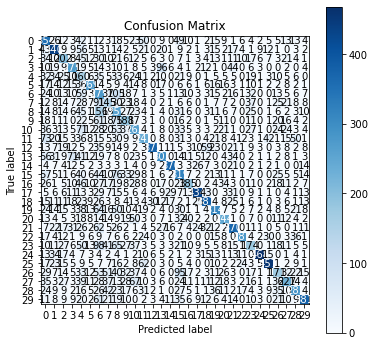

In [10]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, AudioConc, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train, y_train)
print("Accuracy =",knn.score(x_test,y_test))

y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'knn.pkl'), 'wb') as file:
        pkl.dump(knn, file)

### SVM
* **Usiamo il dataset composto**

Accuracy iterazione 0: 0.5501467288106335
Accuracy iterazione 1: 0.5434144657345071
Accuracy iterazione 2: 0.559123079578802
Accuracy iterazione 3: 0.5519682320441989
Accuracy iterazione 4: 0.5837361878453039
Accuracy iterazione 5: 0.5688881215469613
Accuracy iterazione 6: 0.5637085635359116
Accuracy iterazione 7: 0.5421270718232044
Accuracy iterazione 8: 0.5341850828729282
Accuracy iterazione 9: 0.542299723756906
10-fold Accuracy= 0.5539597257549357
Accuracy = 0.5290086319644258
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       697
           1       0.52      0.68      0.59       720
           2       0.40      0.43      0.41       513
           3       0.56      0.36      0.44       562
           4       0.50      0.35      0.41       483
           5       0.68      0.51      0.58       515
           6       0.43      0.41      0.42       697
           7       0.39      0.23      0.29       519
           8       0.39     

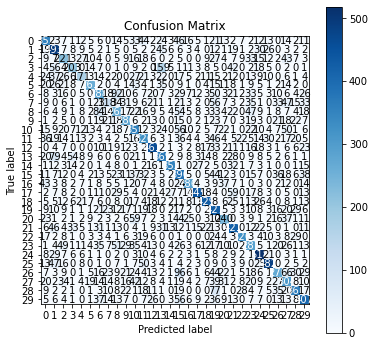

In [7]:
# rbf SVM

svm_rbf=SVC(kernel = 'rbf',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_rbf, AudioMFP_F, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_rbf=svm_rbf.fit(x_train_mel,y_train_mel)
print("Accuracy =",svm_rbf.score(x_test_mel,y_test_mel))

y_pred = svm_rbf.predict(x_test_mel)
print(classification_report(y_test_mel, y_pred))

skplt.metrics.plot_confusion_matrix(y_test_mel,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_rbf.pkl'), 'wb') as file:
        pkl.dump(svm_rbf, file)